# Ideal Parameter Analysis ($\delta=2.25$, $\tau=1.25$, $\alpha=1.85$) ($\alpha$ low)

In [1]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import sys

from datetime import datetime

sys.path.append('../../feeg_fmri_sync')

from feeg_fmri_sync.plotting import (
    plot_all_search_results_2d,
    plot_local_minima
)
from feeg_fmri_sync.search import (
    build_models,
    search_voxels
)
from feeg_fmri_sync.simulations import (
    build_model_to_fmri,
    generate_downsampled_simulated_fmri,
)
from feeg_fmri_sync.utils import (
    generate_descriptions_from_search_df,
)
from feeg_fmri_sync.vectorized_models import VectorizedHemodynamicModel

In [2]:
try_to_reuse = True
submit_to_cluster = False

## Initialize constants for Hemodynamic Modeling

In [3]:
### Initialize constants ###
sample_freq = 20
tr = 800
n_trs_skipped_at_beginning = 0
hemodynamic_response_window = 30

# Actual Values to generate data from
expected_delta = 2.25
expected_tau=1.25
expected_alpha=1.85

## Initialize constants for simulation

In [4]:
# Plot the generated data
# NOTE: only the first of the trials will be plotted
plot_generated_data = True

# Plot perfect data when modeling
plot_perfect_comparison = True

# noises to examine and plot when modeling
noise_range = range(1, 11)  
noises_to_plot = [3, 5, 10]

# trials we run for each condition and how many trials to plot when modeling
num_trials = 100  
num_trials_to_plot = 1

# models to examine
models_to_test = [
    {
        'name': 'downsample',
        'model': VectorizedHemodynamicModel,
        'fmri_data_generator': generate_downsampled_simulated_fmri,
    }
]

# eeg data types to use
eeg_data_options_for_fmri_generation = ['without_nans']
eeg_data_options_for_simulation = ['without_nans', 'with_nans']

## Display Generated Noise against Simulated Ground Truth

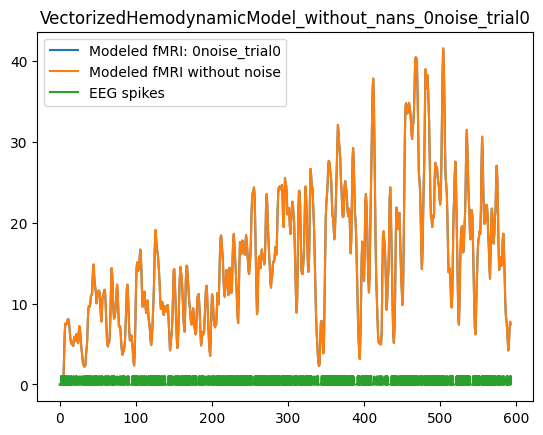

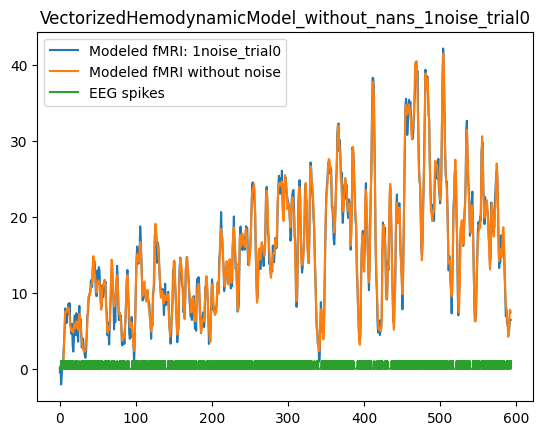

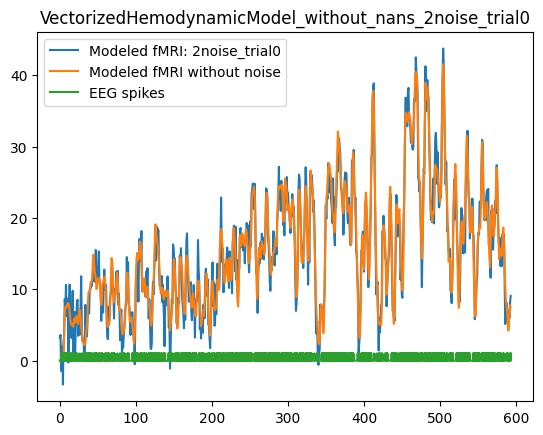

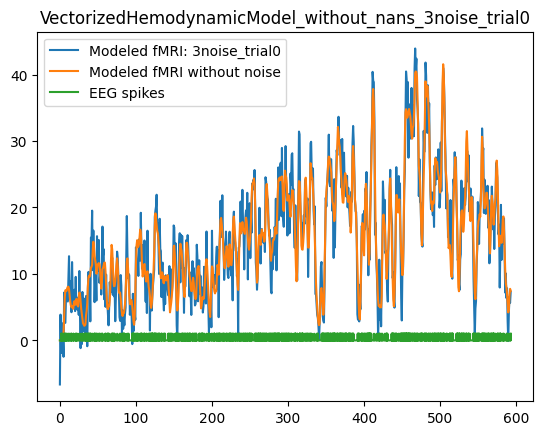

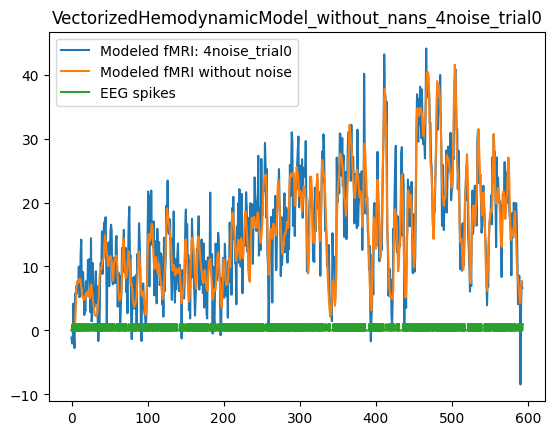

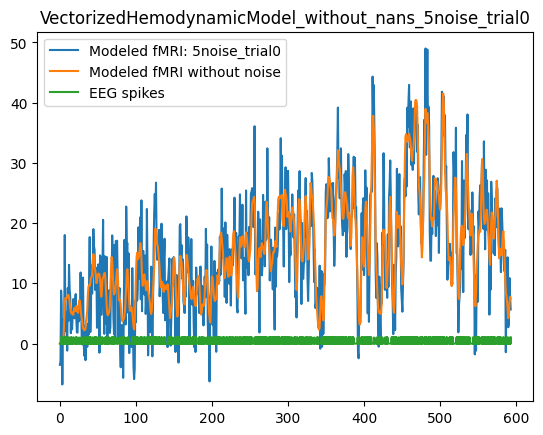

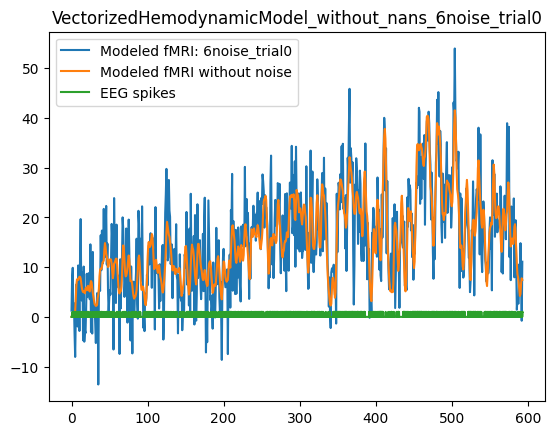

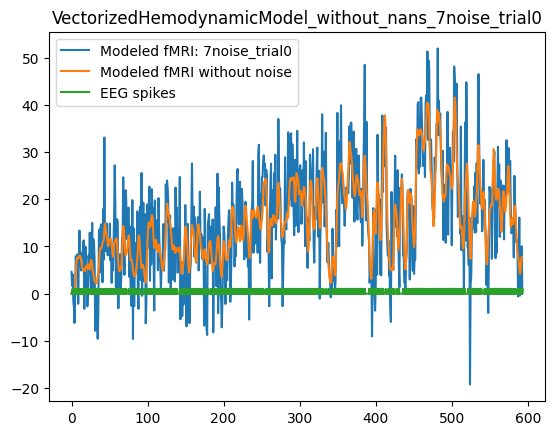

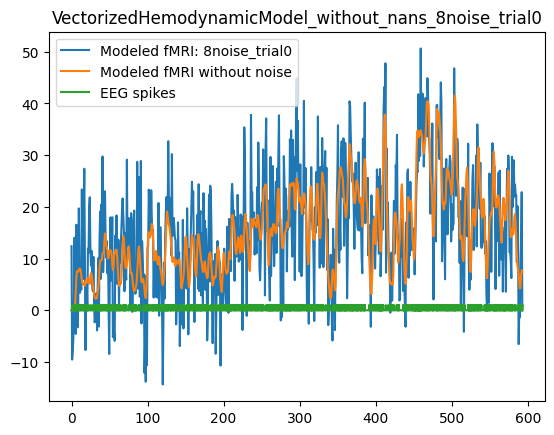

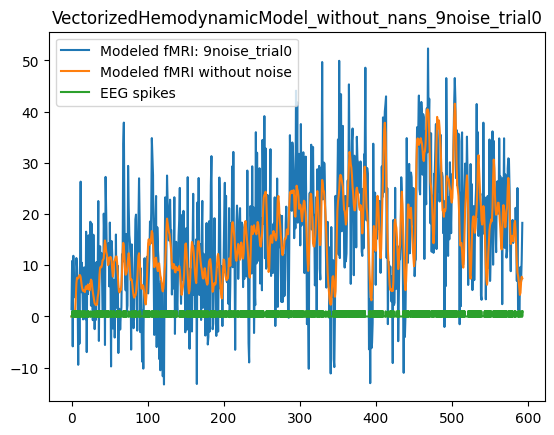

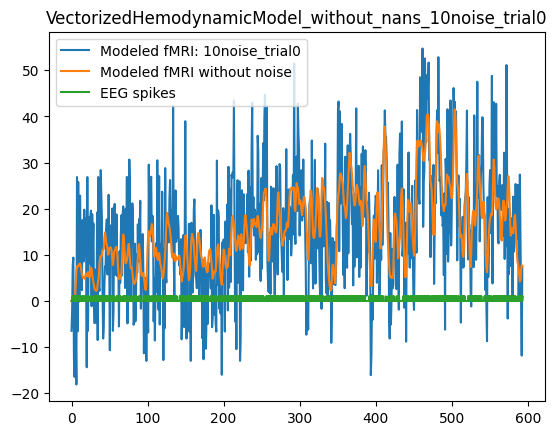

In [5]:
# Generate fMRI data
model_to_fmri = build_model_to_fmri(
    models_to_test,
    eeg_data_options_for_fmri_generation,
    expected_delta,
    expected_tau,
    expected_alpha,
    num_trials,
    num_trials_to_plot,
    noise_range,
    noises_to_plot,
    plot_perfect_comparison,
    tr,
    sample_freq,
    hemodynamic_response_window,
    plot_generated_data
)


## Initialize Analysis variables

In [6]:
step_size = 0.05

filename_substring = f'effect_of_ideal_params_delta{expected_delta}_tau{expected_tau}_alpha{expected_alpha}'
filename_ext = '.csv'
plot = True

delta = np.arange(1, 3+step_size, step_size)
tau = np.arange(0.75, 1.75+step_size, step_size)
alpha = np.arange(1.75, 2.25+step_size, step_size)

print(f'Delta target: {expected_delta}, Range:\n{delta}\n')
print(f'Tau target: {expected_tau}, Range:\n{tau}\n')
print(f'Alpha target: {expected_alpha}, Range:\n{alpha}\n')

Delta target: 2.25, Range:
[1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4  1.45 1.5  1.55 1.6  1.65
 1.7  1.75 1.8  1.85 1.9  1.95 2.   2.05 2.1  2.15 2.2  2.25 2.3  2.35
 2.4  2.45 2.5  2.55 2.6  2.65 2.7  2.75 2.8  2.85 2.9  2.95 3.  ]

Tau target: 1.25, Range:
[0.75 0.8  0.85 0.9  0.95 1.   1.05 1.1  1.15 1.2  1.25 1.3  1.35 1.4
 1.45 1.5  1.55 1.6  1.65 1.7  1.75]

Alpha target: 1.85, Range:
[1.75 1.8  1.85 1.9  1.95 2.   2.05 2.1  2.15 2.2  2.25]



## Est vs Actual for all models at correct points

Scoring downsample_without_nans_without_nans delta=2.25, tau=1.25, alpha=1.85


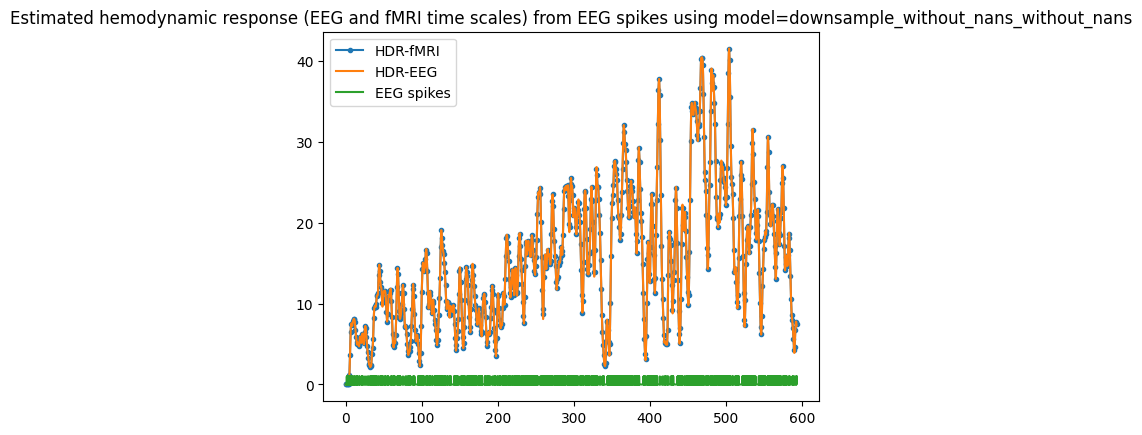

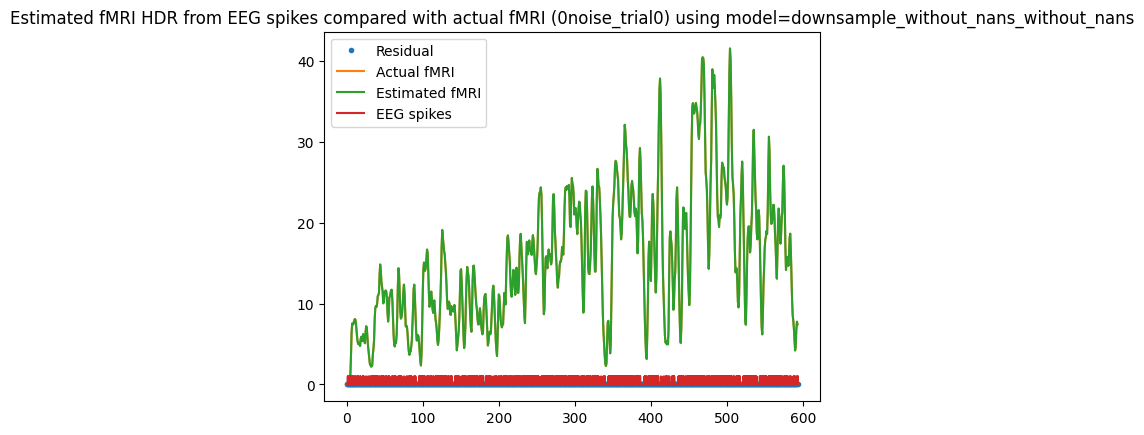

Residual Variance is 0.000000


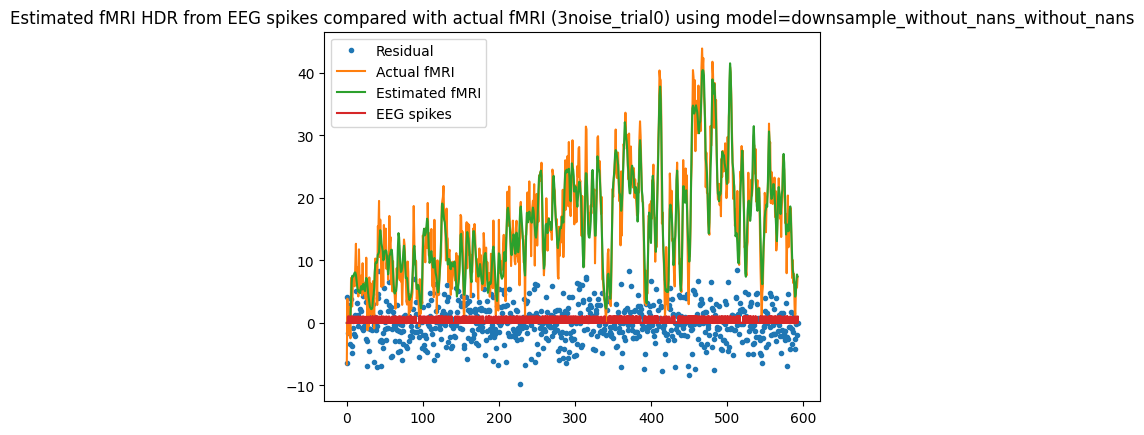

Residual Variance is 9.102604


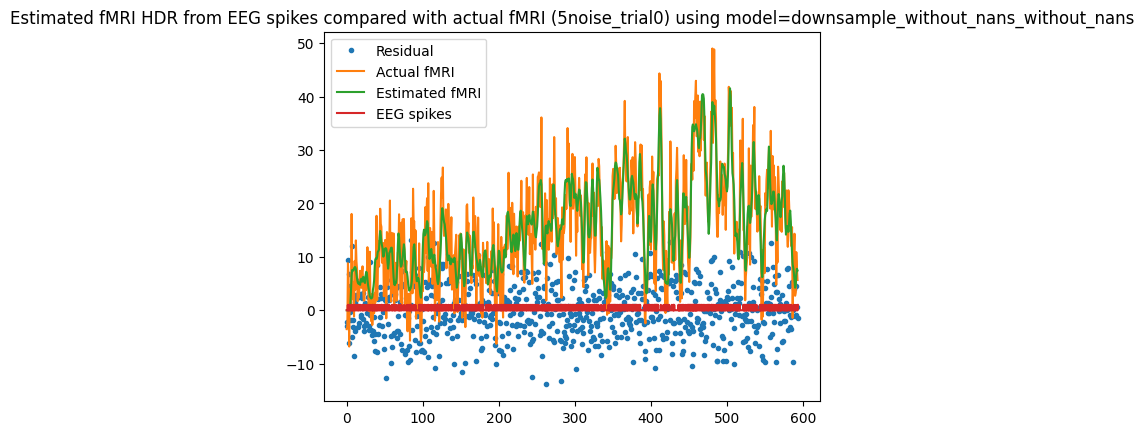

Residual Variance is 25.372733


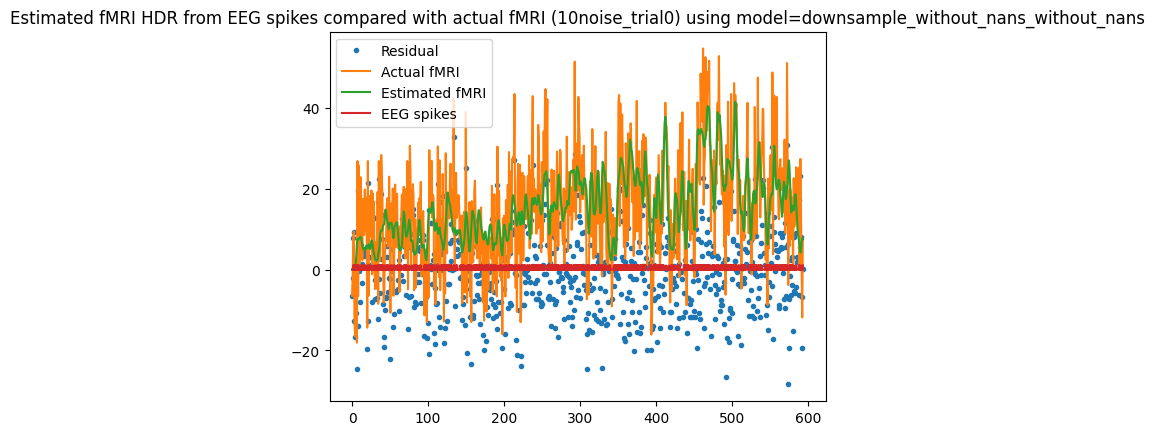

Residual Variance is 107.215259


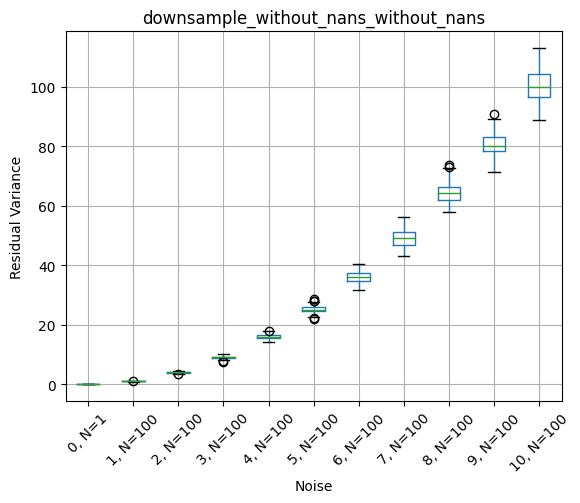

Scoring downsample_without_nans_with_nans delta=2.25, tau=1.25, alpha=1.85


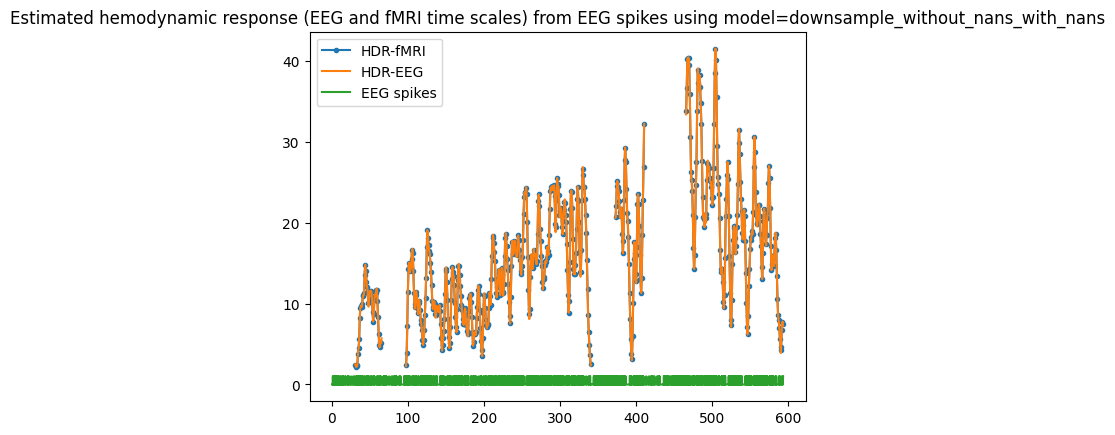

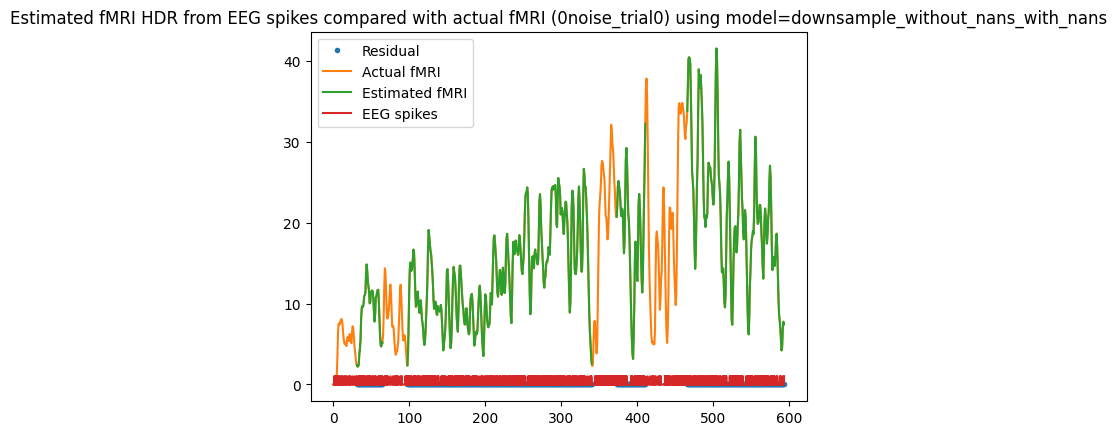

Residual Variance is 0.000000


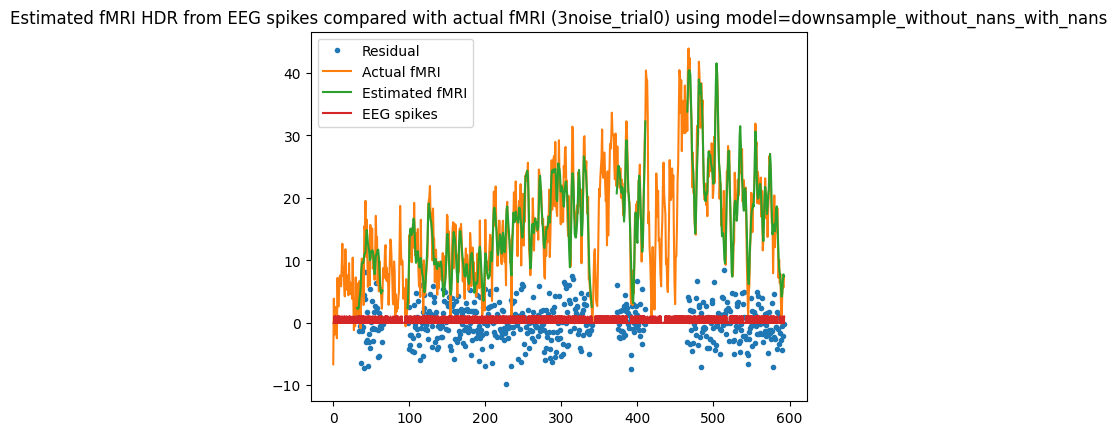

Residual Variance is 8.959271


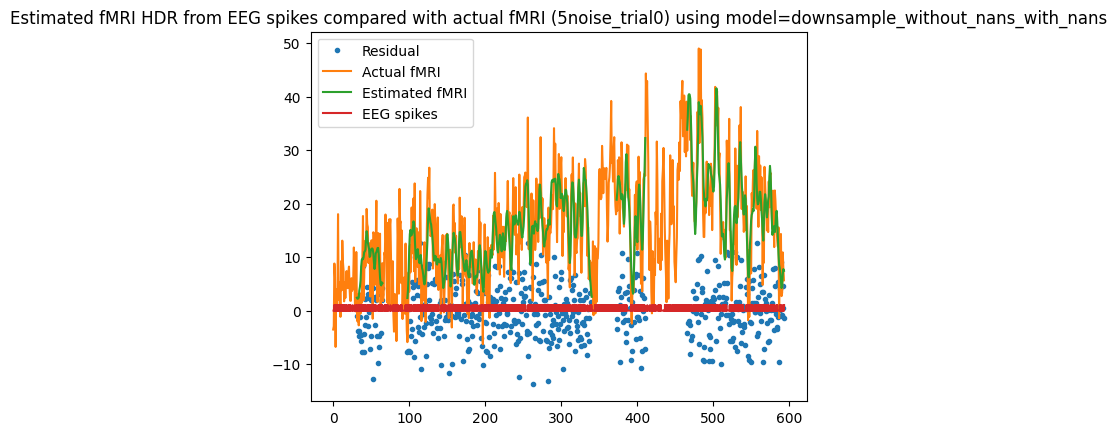

Residual Variance is 25.357048


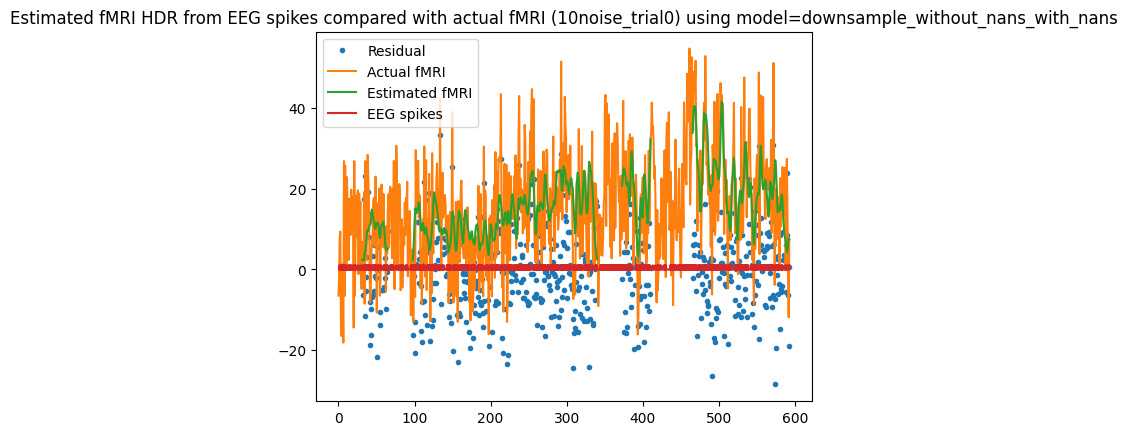

Residual Variance is 107.686335


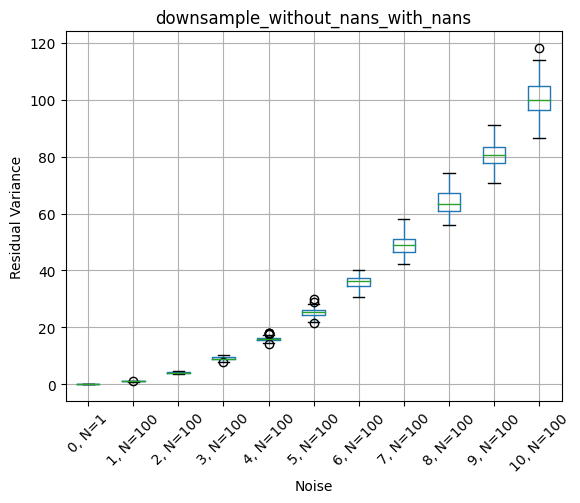

In [7]:
models = build_models(
    model_to_fmri,
    eeg_data_options_for_simulation,
    tr, 
    n_trs_skipped_at_beginning,
    sample_freq,
    hemodynamic_response_window,
    plot
)

# Get in-depth plots for actual delta, tau, alpha
for model_name, model in models.items():
    residual_var = model.score(expected_delta, expected_tau, expected_alpha)
    fmri_names = np.array(model.fmri.voxel_names)
    if (fmri_names == None).any():
        print(f'Residual variance was {residual_var}')
    else:
        noise_levels = np.char.replace(fmri_names, 'perfect', '0noise_trail0')
        noise_levels = np.char.partition(noise_levels, sep='noise')
        res_var_df = pd.DataFrame(zip(noise_levels[:,0].astype(int), residual_var), columns=['Noise', 'res_var'])
        res_var_by_noise = res_var_df.groupby('Noise')
        _, axs = plt.subplots()
        axs.set_title(model_name)
        axs.set_ylabel('Residual Variance')
        axs.set_xlabel('Noise')
        axs = res_var_by_noise.boxplot(column='res_var', subplots=False, rot=45, ax=axs)
        labels = res_var_by_noise.count()
        labels = [f'{noise}, N={n.item()}' for noise, n in zip(labels.index, labels.values)]
        plt.setp(axs, xticklabels=labels)
        plt.show()
    model.plot = False

## Generate/Load the full dataset

In [8]:
# Optional Reuse functionality

df = pd.DataFrame()
descriptions = []

if try_to_reuse:
    matching_files = sorted(glob.glob(f'{filename_substring}*{filename_ext}'))
    filename_to_use = "none"
    if len(matching_files) != 0:
        filename_to_use = input(
            f'Found previously run data. Enter name to reuse or "none" to recalculate.'
            f'\n{matching_files}\nDefault ({matching_files[-1]})\n'
        )
    if filename_to_use.lower() != "none":
        if filename_to_use.strip() == '':
            filename_to_use = matching_files[-1]
        print(f'Loading data from {filename_to_use}...')
        with open(filename_to_use, 'r') as f:
            df = pd.read_csv(f, index_col=0)
        descriptions = generate_descriptions_from_search_df(df, models)


In [9]:
if df.empty:
    if submit_to_cluster:
        raise NotImplemented("Submitting to the cluster is not implemented!")
    print('Generating data!')
    descriptions, df = search_voxels(models, delta, tau, alpha)
    with open(f'{filename_substring}_{datetime.now().strftime("%Y-%m-%d_%H:%M")}{filename_ext}', 'w') as f:
        pd.DataFrame(df).to_csv(f)
    for model_name, description in zip(models.keys(), descriptions):
        with open(f'{model_name}_summary_{filename_substring}_{datetime.now().strftime("%Y-%m-%d_%H:%M")}{filename_ext}', 'w') as f:
            pd.DataFrame(description).transpose().to_csv(f)

df

Generating data!
Scoring delta=1.0
Scoring delta=1.05
Scoring delta=1.1
Scoring delta=1.1500000000000001
Scoring delta=1.2000000000000002
Scoring delta=1.2500000000000002
Scoring delta=1.3000000000000003
Scoring delta=1.3500000000000003
Scoring delta=1.4000000000000004
Scoring delta=1.4500000000000004
Scoring delta=1.5000000000000004
Scoring delta=1.5500000000000005
Scoring delta=1.6000000000000005
Scoring delta=1.6500000000000006
Scoring delta=1.7000000000000006
Scoring delta=1.7500000000000007
Scoring delta=1.8000000000000007
Scoring delta=1.8500000000000008
Scoring delta=1.9000000000000008
Scoring delta=1.9500000000000008
Scoring delta=2.000000000000001
Scoring delta=2.0500000000000007
Scoring delta=2.100000000000001
Scoring delta=2.1500000000000012
Scoring delta=2.200000000000001
Scoring delta=2.250000000000001
Scoring delta=2.300000000000001
Scoring delta=2.3500000000000014
Scoring delta=2.4000000000000012
Scoring delta=2.450000000000001
Scoring delta=2.5000000000000013
Scoring de

delta                 tau               alpha  \
0                     1.0                0.75                1.75   
1                     1.0                0.75                1.75   
2                     1.0                0.75                 1.8   
3                     1.0                0.75                 1.8   
4                     1.0                0.75                1.85   
...                   ...                 ...                 ...   
18937  3.0000000000000018  1.7500000000000009  2.1500000000000004   
18938  3.0000000000000018  1.7500000000000009                 2.2   
18939  3.0000000000000018  1.7500000000000009                 2.2   
18940  3.0000000000000018  1.7500000000000009  2.2500000000000004   
18941  3.0000000000000018  1.7500000000000009  2.2500000000000004   

                                 model_name       0noise_trial0  \
0      downsample_without_nans_without_nans   38.82408963080509   
1         downsample_without_nans_with_nans  35.670180574484675   
2      downsample_without_nans_without_nans   37.96288672900363   
3         downsample_without_nans_with_nans   34.92413814098988   
4      downsample_without_nans_without_nans  37.094851101423195   
...                                     ...                 ...   
18937     downsample_without_nans_with_nans   15.56131556809683   
18938  downsample_without_nans_without_nans  17.686965377499597   
18939     downsample_without_nans_with_nans   16.22831497853189   
18940  downsample_without_nans_without_nans  18.436857319624536   
18941     downsample_without_nans_with_nans   16.88575916576321   

            1noise_trial0       2noise_trial0       3noise_trial0  \
0       40.25384071320547   42.43330054482267   48.62757878195063   
1      36.762906745261816   40.53406398198032   43.51812175561433   
2       39.38796545382918  41.583803417873774  47.755582464573436   
3      36.018153238629644  39.777998050516516  42.793533393089156   
4      38.515366559949406   40.72796818991082   46.87645318457111   
...                   ...                 ...                 ...   
18937  16.400622275633925  20.151314989294384  24.736339266330248   
18938  18.795411992290063  22.396266323989998   27.69475088192577   
18939  17.069253417610494  20.846125767737163   25.40830587286999   
18940  19.553757747028563   23.15857200025783  28.482576649859112   
18941    17.7285773009302  21.530850928030294  26.070112765308657   

            4noise_trial0       5noise_trial0  ...      1noise_trial99  \
0       52.16573154702862   64.06192732394642  ...  38.950047659568256   
1       48.39198045566153   59.26346728277118  ...  35.992726255923124   
2      51.361833377729674   63.11174984791537  ...   38.10016544338877   
3       47.70902251721958   58.44819799681809  ...   35.25783528023666   
4        50.5512726435501   62.15633368097798  ...   37.24382021175658   
...                   ...                 ...  ...                 ...   
18937  27.960055655242908  43.050829474826614  ...  16.091711171343135   
18938  31.229144864471557  45.759576988920486  ...  18.444837497932802   
18939  28.567497444843163  43.726211347610864  ...   16.75249540590925   
18940   31.95207440262231   46.54602970358847  ...   19.18832208126051   
18941  29.168508830443876   44.39034356094847  ...  17.404096904191363   

           2noise_trial99      3noise_trial99      4noise_trial99  \
0       43.50596056588409   46.68523251031725  53.106508744598464   
1       40.37563984814325   42.67000379905604   50.44882542356317   
2      42.615699073941855    45.8100046620501   52.27687785520728   
3       39.59877202941261   41.93660722829574   49.72341822873834   
4      41.718762325436224   44.92802719887994   51.44134376028854   
...                   ...                 ...                 ...   
18937  21.173823013172697  24.296566453373984   31.90872691665193   
18938  23.612859014969498  26.957867914232335   33.94464156147698   
18939  21.858586352837403   24.94831777785841  

## No Noise Analysis - downsample without missing data

### Cost

Minimal Cost for Average Cost: noise 0 (downsample_without_nans_without_nans) = 1.7397742614780893e-28; at
       delta   tau  alpha
11774   2.25  1.25   1.85


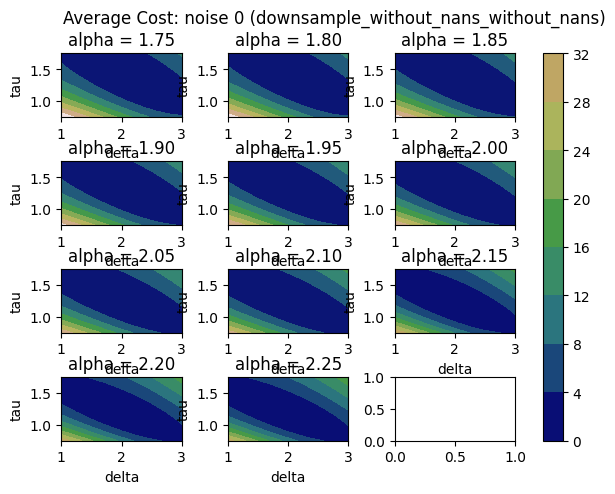

delta   tau  alpha  \
0        1.0  0.75   1.75   
2        1.0  0.75   1.80   
4        1.0  0.75   1.85   
6        1.0  0.75   1.90   
8        1.0  0.75   1.95   
...      ...   ...    ...   
18932    3.0  1.75   2.05   
18934    3.0  1.75   2.10   
18936    3.0  1.75   2.15   
18938    3.0  1.75   2.20   
18940    3.0  1.75   2.25   

       Average Cost: noise 0 (downsample_without_nans_without_nans)  
0                                              38.824090             
2                                              37.962887             
4                                              37.094851             
6                                              36.220775             
8                                              35.341471             
...                                                  ...             
18932                                          15.396109             
18934                                          16.165516             
18936                                          16.929511             
18938                                          17.686965             
18940                                          18.436857             

[9471 rows x 4 columns]

In [10]:
model_name = 'downsample_without_nans_without_nans'
noise = 0
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
columns_for_noise = df_to_plot.columns[columns_to_choose]

average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]

average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
plot_all_search_results_2d(average_df, separate_by='alpha')
average_df


In [11]:
data = []

minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()

for point in zip(*np.where(~np.isnan(minimum_cost_array))):
    row_of_interest = df_to_plot.iloc[point[0]]
    data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha']])
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
pd.DataFrame(data, columns=['delta', 'tau', 'alpha'])

Delta target: 2.25, Tau target: 1.25, Alpha target: 1.85


delta   tau  alpha
0   2.25  1.25   1.85

### Local Minima Analysis

In [12]:
delta_unique_values = df_to_plot['delta'].unique()    
tau_unique_values = df_to_plot['tau'].unique()
alpha_unique_values = df_to_plot['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(df_to_plot['delta'].values, new_shape)
tau_pts = np.reshape(df_to_plot['tau'].values, new_shape)
alpha_pts = np.reshape(df_to_plot['alpha'].values, new_shape)

# Find local minima
columns = df_to_plot.columns.drop(['delta', 'tau', 'alpha'])

m = np.reshape(
    df_to_plot[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
noise = 0

columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
for point in local_minima_with_given_noise:
    point_as_list = tuple(point.tolist())
    local_minima.append({
        'noise': noise,
        'iteration': columns[point[-1]].split('trial')[-1],
        'cost': m[point_as_list],
        'delta': delta_pts[point_as_list[:-1]],
        'tau': tau_pts[point_as_list[:-1]],
        'alpha': alpha_pts[point_as_list[:-1]]
    })

local_minima_by_noise = pd.DataFrame(local_minima)
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
local_minima_by_noise

Delta target: 2.25, Tau target: 1.25, Alpha target: 1.85


noise iteration          cost  delta   tau  alpha
0      0         0  1.046867e-02   2.10  1.15   2.20
1      0         0  3.961618e-03   2.20  1.20   2.00
2      0         0  1.739774e-28   2.25  1.25   1.85

In [13]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').mean()

Number of Local Minima
noise                        
0                         3.0

#### Local minima at edges

In [14]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [15]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [16]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [17]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [18]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [19]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

## No Noise Analysis - downsample with missing data

### Cost

Minimal Cost for Average Cost: noise 0 (downsample_without_nans_with_nans) = 7.756157451758453e-29; at
       delta   tau  alpha
11775   2.25  1.25   1.85


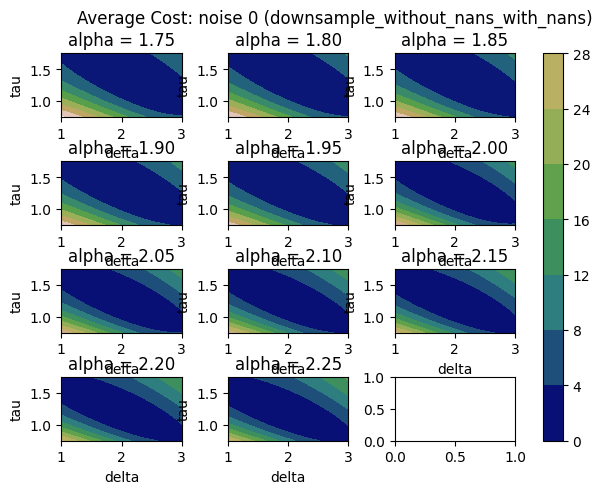

delta   tau  alpha  \
1        1.0  0.75   1.75   
3        1.0  0.75   1.80   
5        1.0  0.75   1.85   
7        1.0  0.75   1.90   
9        1.0  0.75   1.95   
...      ...   ...    ...   
18933    3.0  1.75   2.05   
18935    3.0  1.75   2.10   
18937    3.0  1.75   2.15   
18939    3.0  1.75   2.20   
18941    3.0  1.75   2.25   

       Average Cost: noise 0 (downsample_without_nans_with_nans)  
1                                              35.670181          
3                                              34.924138          
5                                              34.169317          
7                                              33.406392          
9                                              32.636066          
...                                                  ...          
18933                                          14.202307          
18935                                          14.885648          
18937                                          15.561316          
18939                                          16.228315          
18941                                          16.885759          

[9471 rows x 4 columns]

In [20]:
model_name = 'downsample_without_nans_with_nans'
noise = 0
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
columns_for_noise = df_to_plot.columns[columns_to_choose]

average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]

average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
plot_all_search_results_2d(average_df, separate_by='alpha')
average_df


In [21]:
data = []

minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()

for point in zip(*np.where(~np.isnan(minimum_cost_array))):
    row_of_interest = df_to_plot.iloc[point[0]]
    data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha']])
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
pd.DataFrame(data, columns=['delta', 'tau', 'alpha'])

Delta target: 2.25, Tau target: 1.25, Alpha target: 1.85


delta   tau  alpha
0   2.25  1.25   1.85

### Local Minima Analysis

In [22]:
delta_unique_values = df_to_plot['delta'].unique()    
tau_unique_values = df_to_plot['tau'].unique()
alpha_unique_values = df_to_plot['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(df_to_plot['delta'].values, new_shape)
tau_pts = np.reshape(df_to_plot['tau'].values, new_shape)
alpha_pts = np.reshape(df_to_plot['alpha'].values, new_shape)

# Find local minima
columns = df_to_plot.columns.drop(['delta', 'tau', 'alpha'])

m = np.reshape(
    df_to_plot[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
noise = 0

columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
for point in local_minima_with_given_noise:
    point_as_list = tuple(point.tolist())
    local_minima.append({
        'noise': noise,
        'iteration': columns[point[-1]].split('trial')[-1],
        'cost': m[point_as_list],
        'delta': delta_pts[point_as_list[:-1]],
        'tau': tau_pts[point_as_list[:-1]],
        'alpha': alpha_pts[point_as_list[:-1]]
    })

local_minima_by_noise = pd.DataFrame(local_minima)
print(f'Delta target: {expected_delta}, Tau target: {expected_tau}, Alpha target: {expected_alpha}')
local_minima_by_noise

Delta target: 2.25, Tau target: 1.25, Alpha target: 1.85


noise iteration          cost  delta   tau  alpha
0      0         0  1.062713e-02   2.10  1.15   2.20
1      0         0  3.999652e-03   2.20  1.20   2.00
2      0         0  7.756157e-29   2.25  1.25   1.85

In [23]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').mean()

Number of Local Minima
noise                        
0                         3.0

#### Local minima at edges

In [24]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [25]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [26]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [27]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [28]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [29]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

## Cost by Noise

### Downsample without Missing Data

Minimal Cost for Average Cost: noise 1 (downsample_without_nans_without_nans) = 0.9979727214471642; at
       delta   tau  alpha
11774   2.25  1.25   1.85


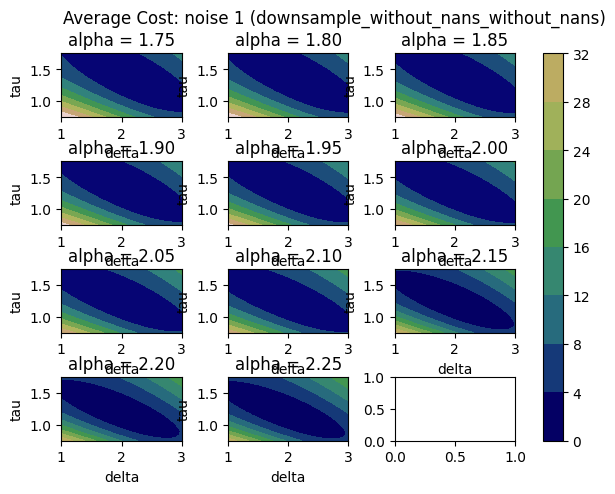

Minimal Cost for Average Cost: noise 2 (downsample_without_nans_without_nans) = 4.001435411477983; at
       delta   tau  alpha
11774   2.25  1.25   1.85


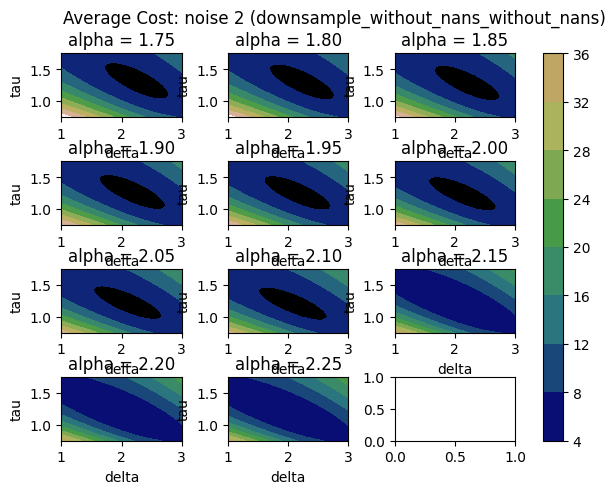

Minimal Cost for Average Cost: noise 3 (downsample_without_nans_without_nans) = 9.00177850417637; at
       delta   tau  alpha
11774   2.25  1.25   1.85


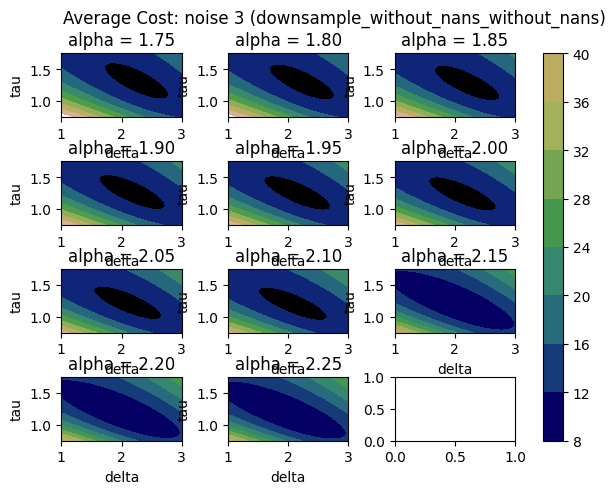

Minimal Cost for Average Cost: noise 4 (downsample_without_nans_without_nans) = 16.001624169769393; at
       delta   tau  alpha
11314    2.2  1.25    1.9


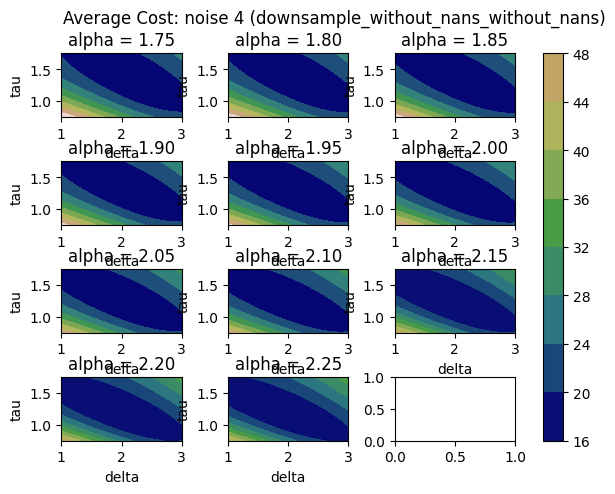

Minimal Cost for Average Cost: noise 5 (downsample_without_nans_without_nans) = 25.13102496683062; at
       delta   tau  alpha
12234    2.3  1.25    1.8


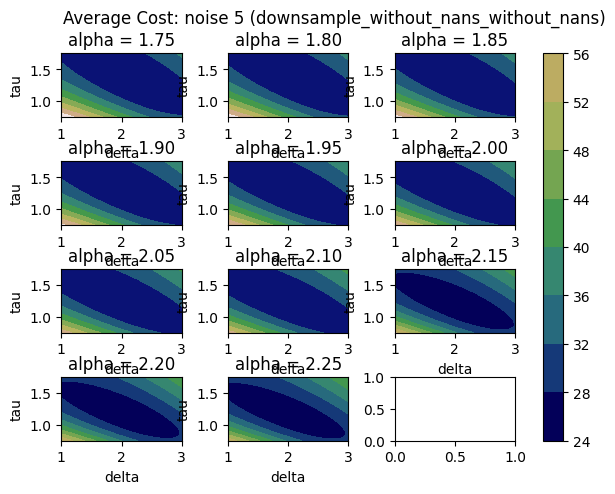

Minimal Cost for Average Cost: noise 6 (downsample_without_nans_without_nans) = 36.10950336495717; at
       delta  tau  alpha
11296    2.2  1.2    2.0


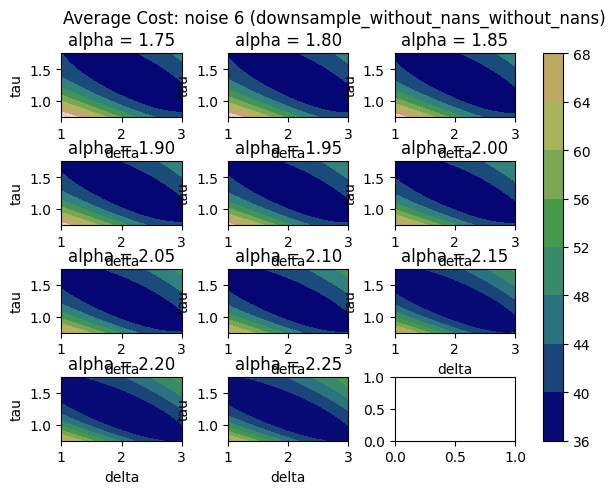

Minimal Cost for Average Cost: noise 7 (downsample_without_nans_without_nans) = 48.98196195839403; at
       delta   tau  alpha
11774   2.25  1.25   1.85


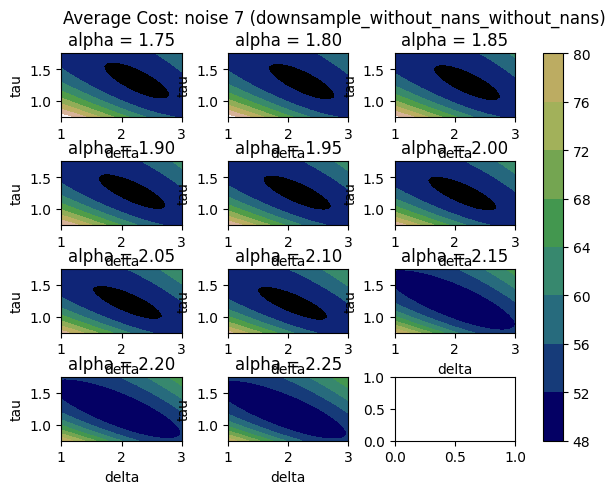

Minimal Cost for Average Cost: noise 8 (downsample_without_nans_without_nans) = 64.18264112472326; at
       delta   tau  alpha
11774   2.25  1.25   1.85


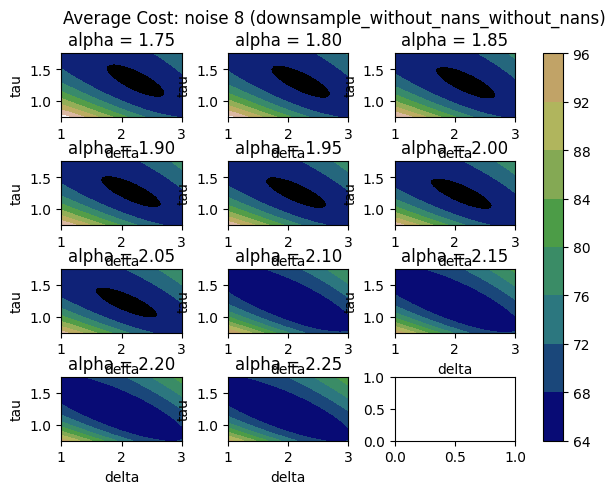

Minimal Cost for Average Cost: noise 9 (downsample_without_nans_without_nans) = 80.74570722002422; at
       delta   tau  alpha
11774   2.25  1.25   1.85


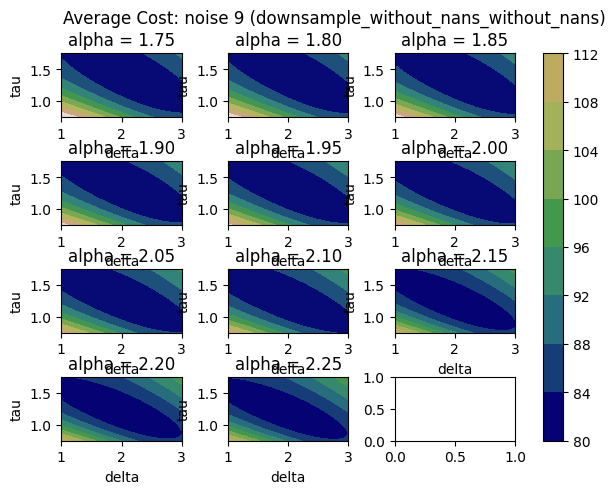

Minimal Cost for Average Cost: noise 10 (downsample_without_nans_without_nans) = 100.33108112348452; at
       delta   tau  alpha
11774   2.25  1.25   1.85


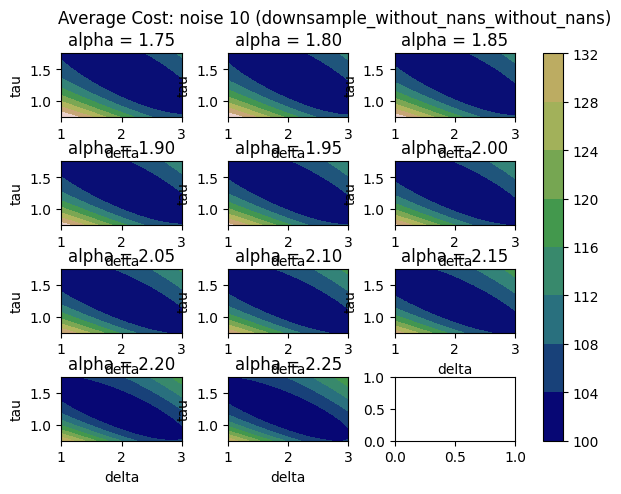

In [30]:
model_name = 'downsample_without_nans_without_nans'
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]

    average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]
    average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
    plot_all_search_results_2d(average_df, separate_by='alpha')

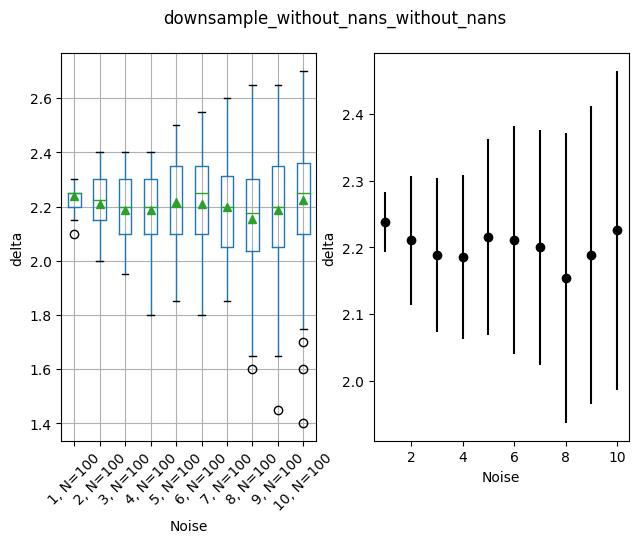

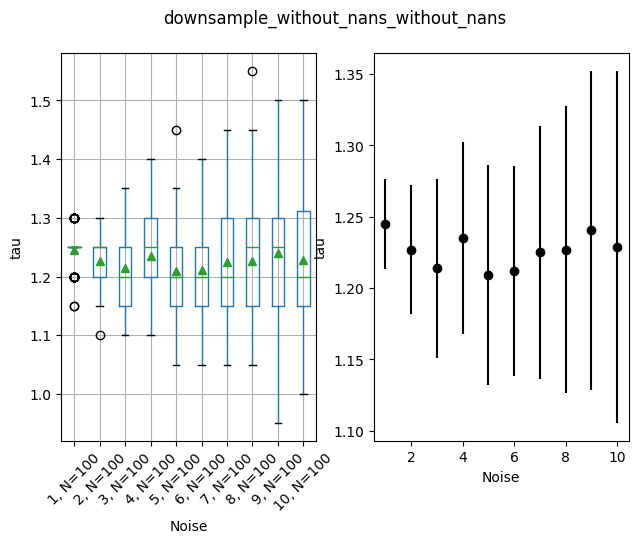

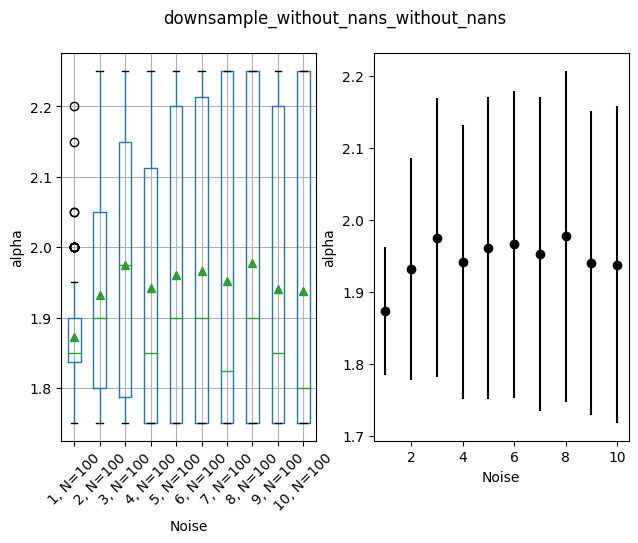

In [31]:
data = []
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]
    minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
    minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()
    
    for point in zip(*np.where(~np.isnan(minimum_cost_array))):
        row_of_interest = df_to_plot.iloc[point[0]]
        data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha'], noise])

chosen_points = pd.DataFrame(data, columns=['delta', 'tau', 'alpha', 'noise']).groupby('noise')

for variable in ['delta', 'tau', 'alpha']:
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(model_name)
    fig.tight_layout()
    axs[0].set_ylabel(variable)
    axs[0].set_xlabel('Noise')
    axs[0] = chosen_points.boxplot(subplots=False, column=variable, rot=45, ax=axs[0], showmeans=True)
    axs[1].set_ylabel(variable)
    axs[1].set_xlabel('Noise')
    axs[1].errorbar(noise_range, chosen_points.mean()[variable], chosen_points.std()[variable], fmt='ok')
    labels = chosen_points.count()
    labels = [f'{noise}, N={n[0].item()}' for noise, n in zip(labels.index, labels.values)]
    plt.setp(axs[0], xticklabels=labels)
    plt.show()

### Downsample with Missing Data

Minimal Cost for Average Cost: noise 1 (downsample_without_nans_with_nans) = 0.991649143859166; at
       delta   tau  alpha
11775   2.25  1.25   1.85


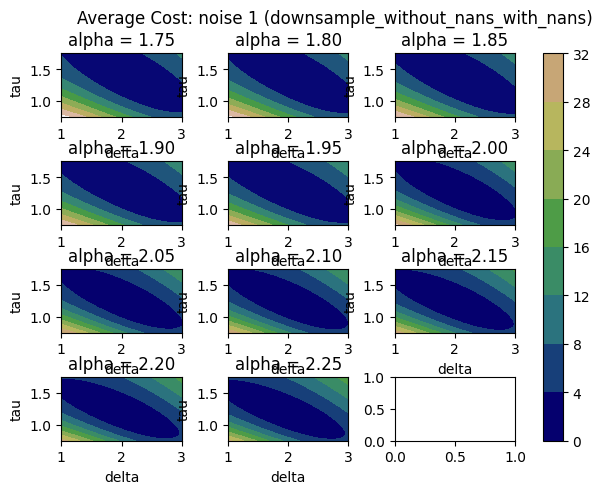

Minimal Cost for Average Cost: noise 2 (downsample_without_nans_with_nans) = 4.0013232428687004; at
       delta   tau  alpha
11775   2.25  1.25   1.85


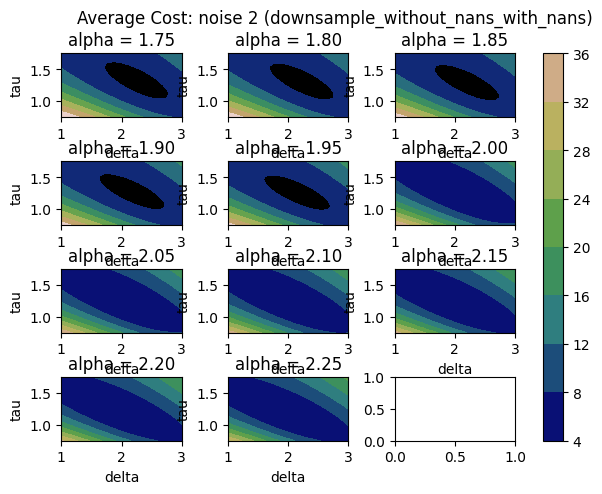

Minimal Cost for Average Cost: noise 3 (downsample_without_nans_with_nans) = 9.006136919707515; at
       delta   tau  alpha
11775   2.25  1.25   1.85


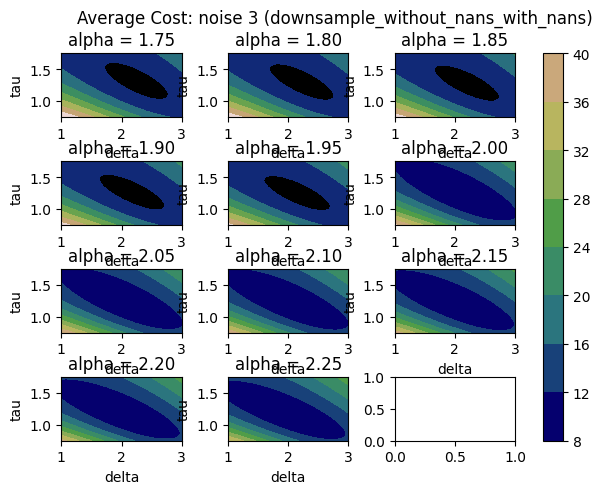

Minimal Cost for Average Cost: noise 4 (downsample_without_nans_with_nans) = 15.995055687341576; at
       delta   tau  alpha
11315    2.2  1.25    1.9


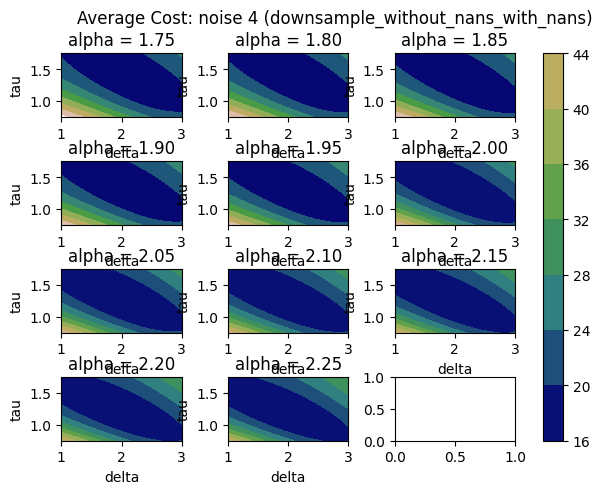

Minimal Cost for Average Cost: noise 5 (downsample_without_nans_with_nans) = 25.232294125475942; at
       delta  tau  alpha
11297    2.2  1.2    2.0


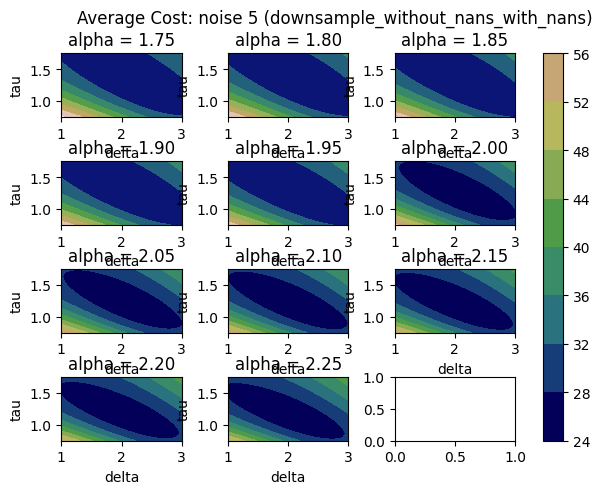

Minimal Cost for Average Cost: noise 6 (downsample_without_nans_with_nans) = 35.96829687809145; at
       delta  tau  alpha
11297    2.2  1.2    2.0


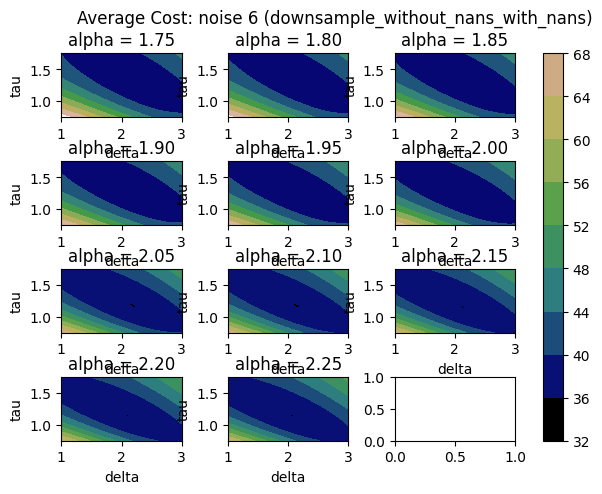

Minimal Cost for Average Cost: noise 7 (downsample_without_nans_with_nans) = 48.940821188242445; at
       delta   tau  alpha
11775   2.25  1.25   1.85


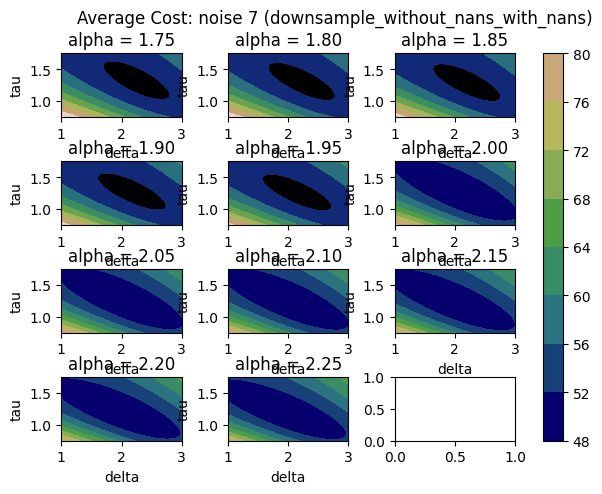

Minimal Cost for Average Cost: noise 8 (downsample_without_nans_with_nans) = 63.934624268909914; at
       delta   tau  alpha
11775   2.25  1.25   1.85


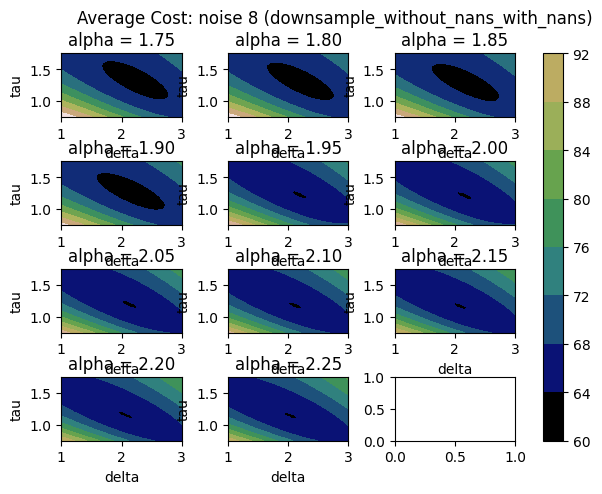

Minimal Cost for Average Cost: noise 9 (downsample_without_nans_with_nans) = 80.85333192854768; at
       delta  tau  alpha
12255    2.3  1.3   1.75


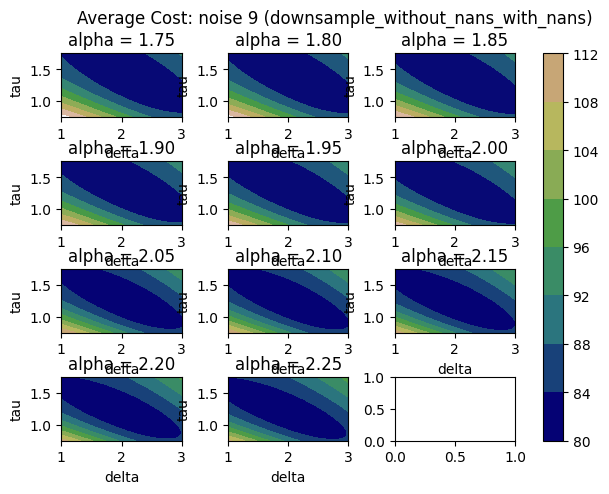

Minimal Cost for Average Cost: noise 10 (downsample_without_nans_with_nans) = 100.34307985237109; at
       delta   tau  alpha
12237    2.3  1.25   1.85


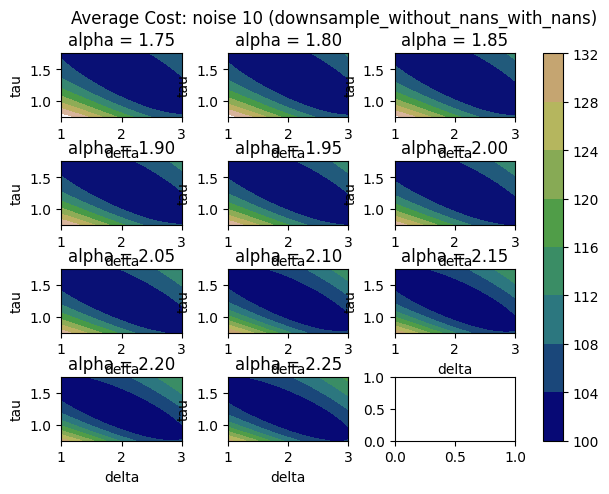

In [32]:
model_name = 'downsample_without_nans_with_nans'
df_to_plot = df[df['model_name'] == model_name].drop(columns='model_name').astype(float)
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]

    average_df = df_to_plot.loc[:,['delta', 'tau', 'alpha']]
    average_df[f'Average Cost: noise {noise} ({model_name})'] = df_to_plot[columns_for_noise].mean(axis=1)
    plot_all_search_results_2d(average_df, separate_by='alpha')


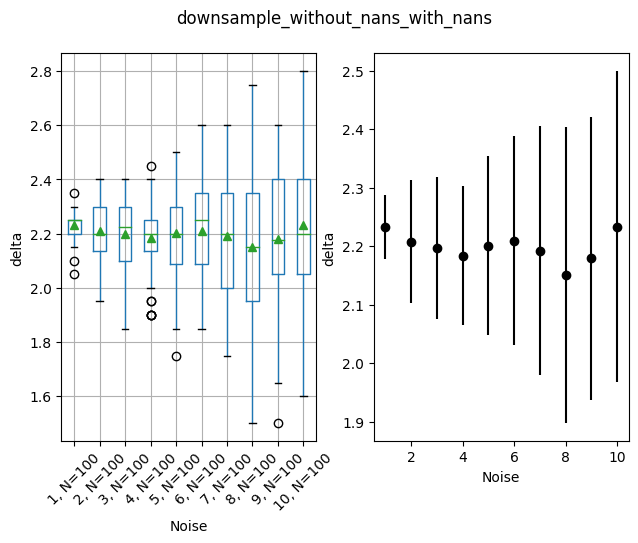

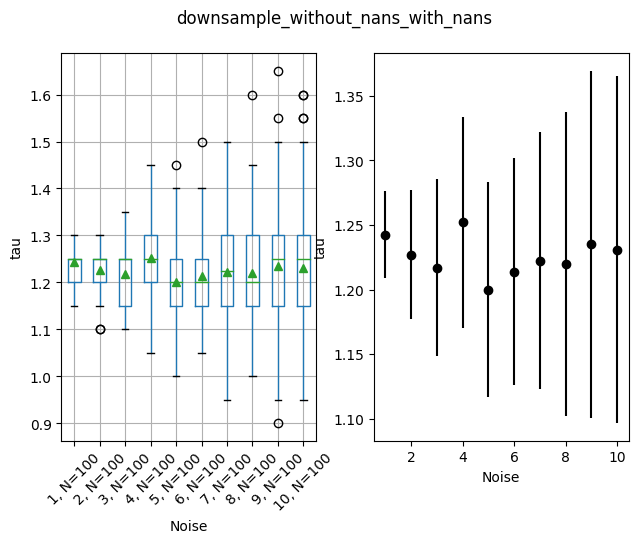

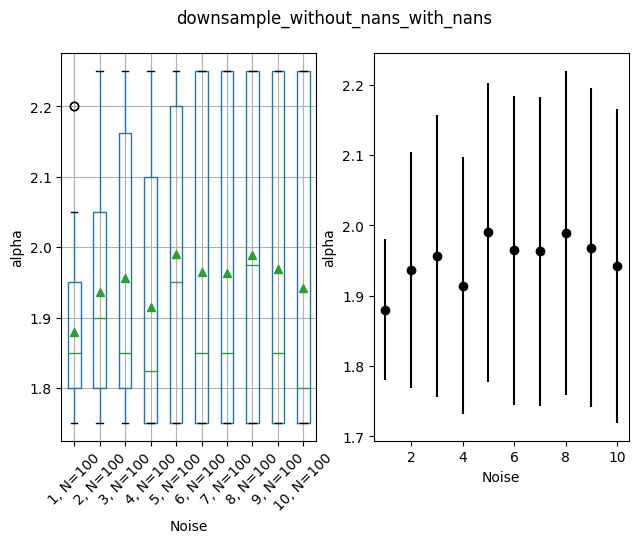

In [33]:
data = []
for noise in noise_range:
    columns_to_choose = np.char.startswith(df_to_plot.columns.to_numpy().astype(str), f'{noise}noise')
    columns_for_noise = df_to_plot.columns[columns_to_choose]
    minimum_cost_mask = df_to_plot[columns_for_noise] == df_to_plot[columns_for_noise].min()
    minimum_cost_array = df_to_plot[columns_for_noise][minimum_cost_mask].to_numpy()
    
    for point in zip(*np.where(~np.isnan(minimum_cost_array))):
        row_of_interest = df_to_plot.iloc[point[0]]
        data.append([row_of_interest['delta'], row_of_interest['tau'], row_of_interest['alpha'], noise])

chosen_points = pd.DataFrame(data, columns=['delta', 'tau', 'alpha', 'noise']).groupby('noise')

for variable in ['delta', 'tau', 'alpha']:
    fig, axs = plt.subplots(1, 2)
    fig.suptitle(model_name)
    fig.tight_layout()
    axs[0].set_ylabel(variable)
    axs[0].set_xlabel('Noise')
    axs[0] = chosen_points.boxplot(subplots=False, column=variable, rot=45, ax=axs[0], showmeans=True)
    axs[1].set_ylabel(variable)
    axs[1].set_xlabel('Noise')
    axs[1].errorbar(noise_range, chosen_points.mean()[variable], chosen_points.std()[variable], fmt='ok')
    labels = chosen_points.count()
    labels = [f'{noise}, N={n[0].item()}' for noise, n in zip(labels.index, labels.values)]
    plt.setp(axs[0], xticklabels=labels)
    plt.show()

## Local Minima Analysis

### Downsample without missing data

In [34]:
model = df['model_name'].unique()[0]
print(f"For Model '{model}'")
portion_df = df[df['model_name'] == model].drop(columns='model_name')
delta_unique_values = portion_df['delta'].unique()    
tau_unique_values = portion_df['tau'].unique()
alpha_unique_values = portion_df['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(portion_df['delta'].values, new_shape)
tau_pts = np.reshape(portion_df['tau'].values, new_shape)
alpha_pts = np.reshape(portion_df['alpha'].values, new_shape)

For Model 'downsample_without_nans_without_nans'


In [35]:
# Find local minima
columns = portion_df.columns.drop(['delta', 'tau', 'alpha'])
     
m = np.reshape(
    portion_df[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

In [36]:
local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
for noise in noise_range:
    columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
    local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
    for point in local_minima_with_given_noise:
        point_as_list = tuple(point.tolist())
        local_minima.append({
            'noise': noise,
            'iteration': columns[point[-1]].split('trial')[-1],
            'cost': m[point_as_list],
            'delta': delta_pts[point_as_list[:-1]],
            'tau': tau_pts[point_as_list[:-1]],
            'alpha': alpha_pts[point_as_list[:-1]]
        })

local_minima_by_noise = pd.DataFrame(local_minima)
local_minima_by_noise


noise iteration        cost               delta                 tau  \
0         1        50    0.927007   2.000000000000001  1.1500000000000004   
1         1         3    1.007617  2.0500000000000007  1.1500000000000004   
2         1         5    1.057973  2.0500000000000007  1.1500000000000004   
3         1         8    0.986523  2.0500000000000007  1.1500000000000004   
4         1        12    0.991994  2.0500000000000007  1.1500000000000004   
...     ...       ...         ...                 ...                 ...   
2680     10        42   99.002631  2.6500000000000012  1.0500000000000003   
2681     10        42   99.001005  2.6500000000000012  1.1000000000000003   
2682     10        91   96.711637  2.6500000000000012  1.1500000000000004   
2683     10        95  105.445800  2.6500000000000012  1.1500000000000004   
2684     10        95  105.431082  2.7000000000000015  1.2000000000000004   

                   alpha  
0     2.2500000000000004  
1                    2.2  
2                    2.2  
3                    2.2  
4                    2.2  
...                  ...  
2680                1.85  
2681                1.75  
2682                1.75  
2683  1.9500000000000002  
2684                 1.8  

[2685 rows x 6 columns]

In [37]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').describe()

Number of Local Minima                                         
                       count  mean       std  min  25%  50%  75%  max
noise                                                                
1                      100.0  3.47  0.501614  3.0  3.0  3.0  4.0  4.0
2                      100.0  3.29  0.742573  1.0  3.0  3.0  4.0  4.0
3                      100.0  2.97  0.904031  1.0  3.0  3.0  4.0  4.0
4                      100.0  2.98  1.034555  1.0  2.0  3.0  4.0  5.0
5                      100.0  2.71  1.112782  1.0  2.0  3.0  4.0  4.0
6                      100.0  2.59  1.045384  1.0  2.0  3.0  3.0  4.0
7                      100.0  2.27  1.099633  1.0  1.0  2.0  3.0  4.0
8                      100.0  2.26  1.211227  1.0  1.0  2.0  3.0  4.0
9                      100.0  2.31  1.178040  1.0  1.0  2.0  3.0  4.0
10                     100.0  2.00  1.073087  1.0  1.0  2.0  3.0  4.0

#### Local minima at edges

In [38]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [39]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [40]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [41]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [42]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration        cost               delta                 tau  \
283       1         3    1.000462   2.250000000000001  1.3000000000000005   
284       1         5    1.053319   2.250000000000001  1.3000000000000005   
285       1         8    0.984578   2.250000000000001  1.3000000000000005   
286       1        12    0.969729   2.250000000000001  1.3000000000000005   
287       1        14    1.001021   2.250000000000001  1.3000000000000005   
...     ...       ...         ...                 ...                 ...   
2670     10        21  102.025207  2.5500000000000016  1.1500000000000004   
2675     10        77   97.429450  2.6000000000000014  1.1500000000000004   
2676     10        84  106.354799  2.6000000000000014  1.1500000000000004   
2681     10        42   99.001005  2.6500000000000012  1.1000000000000003   
2682     10        91   96.711637  2.6500000000000012  1.1500000000000004   

     alpha  
283   1.75  
284   1.75  
285   1.75  
286   1.75  
287   1.75  
...    ...  
2670  1.75  
2675  1.75  
2676  1.75  
2681  1.75  
2682  1.75  

[500 rows x 6 columns]

In [43]:
alpha_min.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        47      2   2.250000000000001   27    47      1  1.3000000000000005   
10       52     14   2.300000000000001    7    52     10  1.3500000000000005   
2        45      5   2.250000000000001   17    45      3  1.3000000000000005   
3        44      7   2.250000000000001   13    44      4  1.3000000000000005   
4        55      7   2.300000000000001   14    55      5  1.3000000000000005   
5        54      9  2.3500000000000014   16    54      6  1.2500000000000004   
6        45     10  2.3500000000000014   11    45      7  1.2500000000000004   
7        52     12  2.3500000000000014    9    52      8  1.2500000000000004   
8        51     12  2.4000000000000012   10    51      9  1.3000000000000005   
9        55     16   2.100000000000001    9    55     10  1.3500000000000005   

            
      freq  
noise       
1       47  
10      10  
2       31  
3       26  
4       22  
5       26  
6       19  
7       15  
8       15  
9       13

In [44]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration        cost               delta                 tau  \
0         1        50    0.927007   2.000000000000001  1.1500000000000004   
14        1         6    1.059848  2.0500000000000007  1.1500000000000004   
15        1         7    1.031007  2.0500000000000007  1.1500000000000004   
16        1        17    1.080712  2.0500000000000007  1.1500000000000004   
17        1        25    0.984757  2.0500000000000007  1.1500000000000004   
...     ...       ...         ...                 ...                 ...   
2624     10        65   96.313543  2.3500000000000014  1.0500000000000003   
2634     10        81  107.767613  2.4000000000000012  1.0000000000000002   
2635     10        84  106.352517  2.4000000000000012  1.0000000000000002   
2636     10        89  100.203898  2.4000000000000012  1.0000000000000002   
2652     10        44   97.342683   2.450000000000001  1.1000000000000003   

                   alpha  
0     2.2500000000000004  
14    2.2500000000000004  
15    2.2500000000000004  
16    2.2500000000000004  
17    2.2500000000000004  
...                  ...  
2624  2.2500000000000004  
2634  2.2500000000000004  
2635  2.2500000000000004  
2636  2.2500000000000004  
2652  2.2500000000000004  

[361 rows x 6 columns]

In [45]:
alpha_max.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        18      2  2.0500000000000007   17    18      1  1.1500000000000004   
10       40     18  2.0500000000000007    4    40      8  1.1500000000000004   
2        32      5  2.0500000000000007   10    32      3  1.1500000000000004   
3        30      7   2.000000000000001    7    30      4  1.1500000000000004   
4        34      9  2.0500000000000007    8    34      5  1.1000000000000003   
5        41      9   2.100000000000001    9    41      4  1.1000000000000003   
6        43     13   2.100000000000001    8    43      6  1.1000000000000003   
7        43     12   2.000000000000001    8    43      7  1.1000000000000003   
8        45     14  2.0500000000000007   10    45      7  1.1000000000000003   
9        35     18  2.0500000000000007    5    35     10  1.2000000000000004   

            
      freq  
noise       
1       18  
10       8  
2       21  
3       16  
4       14  
5       21  
6       17  
7       13  
8       16  
9        9

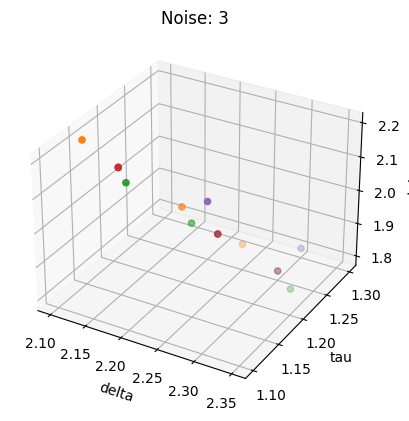

In [46]:
noise = 3
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

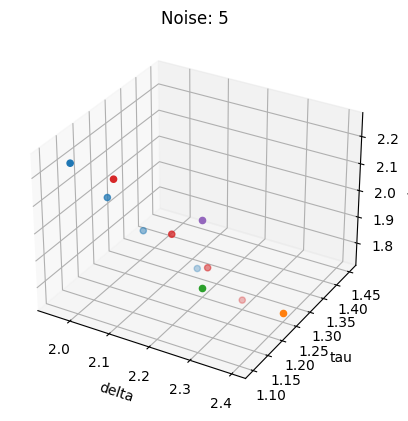

In [47]:
noise = 5
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

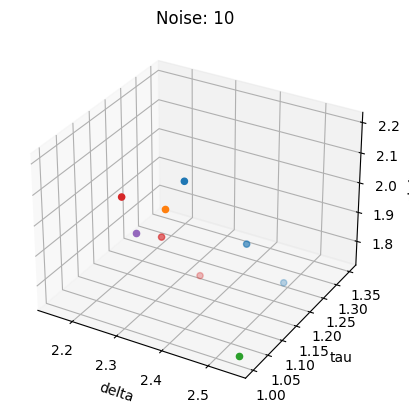

In [48]:
noise = 10
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

### Downsample with missing data

In [49]:
model = df['model_name'].unique()[1]
print(f"For Model '{model}'")
portion_df = df[df['model_name'] == model].drop(columns='model_name')
delta_unique_values = portion_df['delta'].unique()    
tau_unique_values = portion_df['tau'].unique()
alpha_unique_values = portion_df['alpha'].unique()
new_shape = (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size)
delta_pts = np.reshape(portion_df['delta'].values, new_shape)
tau_pts = np.reshape(portion_df['tau'].values, new_shape)
alpha_pts = np.reshape(portion_df['alpha'].values, new_shape)

For Model 'downsample_without_nans_with_nans'


In [50]:
# Find local minima
columns = portion_df.columns.drop(['delta', 'tau', 'alpha'])
     
m = np.reshape(
    portion_df[columns].values.astype(float), 
    (delta_unique_values.size, tau_unique_values.size, alpha_unique_values.size, columns.size)
)

f1 = np.ones((3,3,3,1))
f1[1, 1, 1, 0] = 0
is_minima = m < scipy.ndimage.minimum_filter(m, footprint=f1, mode='constant', cval=np.inf)

In [51]:
local_minima_pts = np.array([pt for pt in zip(*np.where(is_minima))])
local_minima = []
for noise in noise_range:
    columns_with_given_noise = np.where(np.char.startswith(np.array(columns).astype(str), f'{noise}noise'))[0]
    local_minima_with_given_noise = local_minima_pts[np.where(np.isin(local_minima_pts[:,3], columns_with_given_noise))[0],:]
    for point in local_minima_with_given_noise:
        point_as_list = tuple(point.tolist())
        local_minima.append({
            'noise': noise,
            'iteration': columns[point[-1]].split('trial')[-1],
            'cost': m[point_as_list],
            'delta': delta_pts[point_as_list[:-1]],
            'tau': tau_pts[point_as_list[:-1]],
            'alpha': alpha_pts[point_as_list[:-1]]
        })

local_minima_by_noise = pd.DataFrame(local_minima)
local_minima_by_noise


noise iteration        cost               delta                 tau  \
0         1        50    0.911066   2.000000000000001  1.1500000000000004   
1         1        62    1.013451   2.000000000000001  1.1500000000000004   
2         1         3    0.972335  2.0500000000000007  1.1500000000000004   
3         1         5    1.013710  2.0500000000000007  1.1500000000000004   
4         1        14    1.062922  2.0500000000000007  1.1500000000000004   
...     ...       ...         ...                 ...                 ...   
2572     10        89   96.200149  2.8000000000000016  1.1000000000000003   
2573     10        89   96.203807  2.8000000000000016  1.1500000000000004   
2574     10        95  107.210839  2.8000000000000016  1.2500000000000004   
2575     10        44   98.910967   2.950000000000002  1.1000000000000003   
2576     10        44   98.905764  3.0000000000000018  1.1500000000000004   

                   alpha  
0     2.2500000000000004  
1     2.2500000000000004  
2                    2.2  
3                    2.2  
4                    2.2  
...                  ...  
2572                1.85  
2573                1.75  
2574                1.75  
2575                1.85  
2576                1.75  

[2577 rows x 6 columns]

In [52]:
num_local_minima = local_minima_by_noise.drop(columns=['delta', 'tau', 'alpha']).groupby(['noise', 'iteration']).count()

num_local_minima.rename(columns={'cost': 'Number of Local Minima'}).groupby('noise').describe()

Number of Local Minima                                          
                       count  mean       std  min   25%  50%  75%  max
noise                                                                 
1                      100.0  3.50  0.522233  2.0  3.00  4.0  4.0  4.0
2                      100.0  3.16  0.720830  1.0  3.00  3.0  4.0  4.0
3                      100.0  3.03  0.858175  1.0  3.00  3.0  4.0  4.0
4                      100.0  2.78  1.050060  1.0  2.00  3.0  4.0  4.0
5                      100.0  2.63  1.060351  1.0  2.00  3.0  3.0  4.0
6                      100.0  2.36  1.030053  1.0  1.75  2.0  3.0  4.0
7                      100.0  2.19  1.186583  1.0  1.00  2.0  3.0  4.0
8                      100.0  2.02  1.118982  1.0  1.00  2.0  3.0  4.0
9                      100.0  2.02  1.109919  1.0  1.00  2.0  3.0  4.0
10                     100.0  2.08  1.107185  1.0  1.00  2.0  3.0  4.0

#### Local minima at edges

In [53]:
# Delta Min
delta_min = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.min()]
delta_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [54]:
# Delta Max
delta_max = local_minima_by_noise[local_minima_by_noise['delta'] == delta_unique_values.max()]
delta_max

noise iteration       cost               delta                 tau alpha
2576     10        44  98.905764  3.0000000000000018  1.1500000000000004  1.75

In [55]:
# Tau Min
tau_min = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.min()]
tau_min

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [56]:
# Tau Max
tau_max = local_minima_by_noise[local_minima_by_noise['tau'] == tau_unique_values.max()]
tau_max

Empty DataFrame
Columns: [noise, iteration, cost, delta, tau, alpha]
Index: []

In [57]:
# Alpha Min
alpha_min = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.min()]
alpha_min

noise iteration        cost               delta                 tau  \
279       1         3    0.958212   2.250000000000001  1.3000000000000005   
280       1         5    0.999236   2.250000000000001  1.3000000000000005   
281       1        12    0.944218   2.250000000000001  1.3000000000000005   
282       1        14    1.063001   2.250000000000001  1.3000000000000005   
283       1        20    1.045514   2.250000000000001  1.3000000000000005   
...     ...       ...         ...                 ...                 ...   
2566     10        52  110.235998  2.6500000000000012  1.2500000000000004   
2569     10        77   98.641047  2.7000000000000015  1.1000000000000003   
2573     10        89   96.203807  2.8000000000000016  1.1500000000000004   
2574     10        95  107.210839  2.8000000000000016  1.2500000000000004   
2576     10        44   98.905764  3.0000000000000018  1.1500000000000004   

     alpha  
279   1.75  
280   1.75  
281   1.75  
282   1.75  
283   1.75  
...    ...  
2566  1.75  
2569  1.75  
2573  1.75  
2574  1.75  
2576  1.75  

[454 rows x 6 columns]

In [58]:
alpha_min.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        50      3   2.300000000000001   28    50      2  1.3000000000000005   
10       55     17  2.3500000000000014    9    55     13  1.2500000000000004   
2        36      5   2.300000000000001   13    36      3  1.3000000000000005   
3        37      6   2.300000000000001   14    37      2  1.3000000000000005   
4        45      9   2.300000000000001   13    45      5  1.3000000000000005   
5        43     11  2.3500000000000014   10    43      7  1.3000000000000005   
6        39     11  2.3500000000000014    9    39      6  1.2500000000000004   
7        47     13   2.300000000000001    8    47      9  1.2500000000000004   
8        51     14   2.200000000000001    8    51     10  1.3000000000000005   
9        51     15   2.450000000000001    8    51     11  1.3000000000000005   

            
      freq  
noise       
1       49  
10      10  
2       21  
3       19  
4       15  
5       13  
6       14  
7       12  
8       11  
9       10

In [59]:
# Alpha Max
alpha_max = local_minima_by_noise[local_minima_by_noise['alpha'] == alpha_unique_values.max()]
alpha_max

noise iteration        cost               delta                 tau  \
0         1        50    0.911066   2.000000000000001  1.1500000000000004   
1         1        62    1.013451   2.000000000000001  1.1500000000000004   
12        1         0    1.064534  2.0500000000000007  1.1500000000000004   
13        1         6    1.040604  2.0500000000000007  1.1500000000000004   
14        1        17    1.068999  2.0500000000000007  1.1500000000000004   
...     ...       ...         ...                 ...                 ...   
2492     10        53   99.135394   2.300000000000001  1.0500000000000003   
2494     10        97   93.047850   2.300000000000001  1.1000000000000003   
2527     10        77   98.643484  2.4000000000000012  1.0000000000000002   
2552     10        84  112.058586  2.5500000000000016  0.9500000000000002   
2562     10        44   98.898052  2.6500000000000012  1.0500000000000003   

                   alpha  
0     2.2500000000000004  
1     2.2500000000000004  
12    2.2500000000000004  
13    2.2500000000000004  
14    2.2500000000000004  
...                  ...  
2492  2.2500000000000004  
2494  2.2500000000000004  
2527  2.2500000000000004  
2552  2.2500000000000004  
2562  2.2500000000000004  

[378 rows x 6 columns]

In [60]:
alpha_max.astype(str).groupby(['noise'])[['delta', 'tau']].describe()

delta                                   tau                             \
      count unique                 top freq count unique                 top   
noise                                                                          
1        17      3  2.0500000000000007   14    17      2  1.1500000000000004   
10       45     17   2.000000000000001    5    45     10  1.1000000000000003   
2        29      6   2.000000000000001    8    29      3  1.1500000000000004   
3        46      8  2.0500000000000007   12    46      3  1.1500000000000004   
4        38      8  2.0500000000000007   11    38      5  1.1500000000000004   
5        41     11   2.250000000000001    7    41      5  1.1000000000000003   
6        38     13  2.1500000000000012    6    38      5  1.1000000000000003   
7        43     16  1.9500000000000008    6    43      8  1.2000000000000004   
8        41     14  1.9500000000000008    8    41      8  1.2000000000000004   
9        40     20  1.9500000000000008    5    40      9  1.1000000000000003   

            
      freq  
noise       
1       16  
10       9  
2       20  
3       24  
4       15  
5       15  
6       15  
7       14  
8       10  
9       10

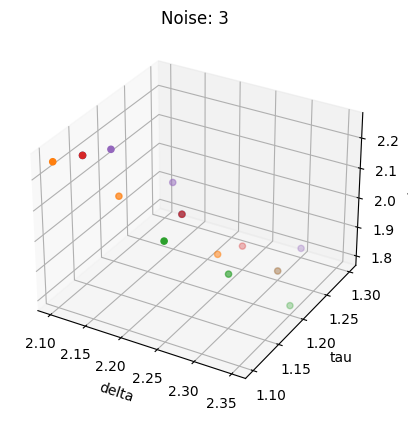

In [61]:
noise = 3
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

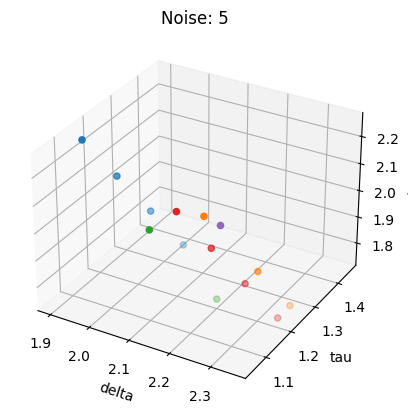

In [62]:
noise = 5
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()

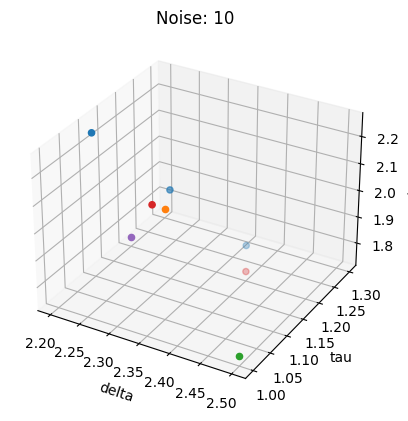

In [63]:
noise = 10
local_minima_at_noise = local_minima_by_noise[local_minima_by_noise['noise'] == noise]
# filter to fewer iterations
subset = local_minima_at_noise[local_minima_at_noise['iteration'].astype(int) < 5]
plt.figure()
ax = plt.axes(projection='3d')
ax.set_title(f'Noise: {noise}')
ax.set_xlabel('delta')
ax.set_ylabel('tau')
ax.set_zlabel('alpha')
for grp_name, grp_idx in subset.groupby('iteration').groups.items():
    ax.scatter(subset.loc[grp_idx, 'delta'].values.astype(float), 
               subset.loc[grp_idx, 'tau'].values.astype(float), 
               subset.loc[grp_idx, 'alpha'].values.astype(float), 
               label=grp_name)
plt.show()